In [ ]:
# Run this only when you need to use Google Colab VM
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CS591 Final Project - AttentionCNN'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1lYi38SsG2Z2EPT3TKcDhd2l4G0Yl2ozC/CS591 Final Project - AttentionCNN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize

In [ ]:
#@title DATALOADER for CIFAR10
# DATALOADER
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5),
    )

    # define transforms
    transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = torchvision.datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform)

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

        return data_loader

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform)

    valid_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [ ]:
#@title DATALOADER for CIFAR100

def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5),
    )

    # define transforms
    transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = torchvision.datasets.CIFAR100(
          root=data_dir, train=False,
          download=True, transform=transform)

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

        return data_loader

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root=data_dir, train=True,
        download=True, transform=transform)

    valid_dataset = torchvision.datasets.CIFAR100(
        root=data_dir, train=True,
        download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [ ]:
import torch
torch.manual_seed(0)
BATCH_SIZE = 4

# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=BATCH_SIZE)

test_loader = data_loader(data_dir='./data',
                              batch_size=BATCH_SIZE,
                              test=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(classes)
# NUM_CLASSES = 100

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


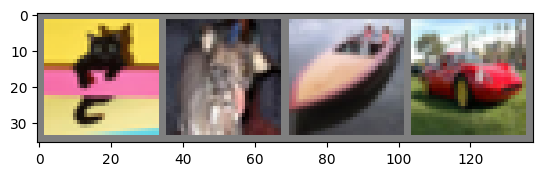

cat   dog   ship  car  
Number of batches, C, H, W: (4, 3, 32, 32)


In [ ]:
# functions to show an image (only works for cifar10 now)
import warnings
warnings.filterwarnings('ignore')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))
dimensions = images.size()
print('Number of batches, C, H, W: ({}, {}, {}, {})'.format(dimensions[0], dimensions[1], dimensions[2], dimensions[3]))

### Define a Convolutional Neural Network with self-attention mechanism

Some other thoughts on architecture:


*   $W_k$, $W_q$, $W_v$ are all $\mathbb{R}^{1 \times 1 \times 1}$. Which is single number. We can make these kernel of $\mathbb{R}^{1 \times 1}$ but we need a fixed number of channels $C^*$, thus will not remain the dimensions of the current feature maps.
*   Attention score is computed using element wise multiplication between $Q$ and $K$. 

*   Softmax is computed based on the ''importance'' of pixel $i$ with respect to all pixels in the same row within the same channel. We can customize this using our instance of softmax where we calculate w.r.t to all pixels within the same channels $→$ need to determine customized autograd function so that it can be updated during backpropogation.



In [ ]:
#@title Single-headed Attention CNN
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, num_heads=1):
        super(AttentionCNN, self).__init__()

        ##############################################
        ##                 LAYER 1                  ##
        ##############################################
        ## Convolution 1
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.rl1 = nn.ReLU()
        ## Attention 1 (Single headed)
        self.key1 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query1 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value1 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        
        ##############################################
        ##                 LAYER 2                  ##
        ##############################################
        ## Convolution 2
        self.conv2 = nn.Conv2d(5, 8, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.rl2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## Attention 2 (Single headed)
        self.key2 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query2 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value2 = nn.Conv2d(8, 1, kernel_size=1, stride=1)

        ##############################################
        ##                 LAYER 3                  ##
        ##############################################
        ## Convolution 3
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.rl3 = nn.ReLU()
        ## Attention 3 (Single headed)
        self.key3 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query3 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value3 = nn.Conv2d(16, 1, kernel_size=1, stride=1)

        ##############################################
        ##                 LAYER 4                  ##
        ##############################################
        ## Convolution 4
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.rl4 = nn.ReLU()
        ## Attention 4 (Single headed)
        self.key4 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query4 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value4 = nn.Conv2d(16, 1, kernel_size=1, stride=1)

        self.aap = nn.AdaptiveAvgPool2d(7) # resize into (C, 7, 7)
 
        # Dense layers
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*16, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, num_classes))
        
    def attention_score(self, x):
        # numerical computation efficiency https://compsci682-fa20.github.io/notes/linear-classify/#softmax
        x = x - torch.max(x) 
        exp_x = torch.exp(x)
        return exp_x / exp_x.sum()

    # FORWARD pass
    def forward(self, x):
        ### Layer 1 ###:
        out = self.conv1(x)
        x = out.clone().detach()
        ## Attention
        # (N,C,H,W) -> (N,1,H,W)
        Q, K, V = self.query1(x), self.key1(x), self.value1(x)
        A = self.attention_score(Q*K)
        y = A*V
        out = y + out
        out = self.bn1(out)
        out = self.rl1(out)

        ### Layer 2 ###:
        out = self.conv2(out)
        x = out.clone().detach()
        Q, K, V = self.query2(x), self.key2(x), self.value2(x)
        A = self.attention_score(Q*K)
        y = A*V
        out = y + out
        out = self.bn2(out)
        out = self.rl2(out)
        out = self.mp2(out)

        ### Layer 3 ###:
        out = self.conv3(out)
        x = out.clone().detach()
        Q, K, V = self.query3(x), self.key3(x), self.value3(x)
        A = self.attention_score(Q*K)
        y = A*V
        out = y + out
        out = self.bn3(out)
        out = self.rl3(out)

        ### Layer 4 ###:
        out = self.conv4(out)
        x = out.clone().detach()
        Q, K, V = self.query4(x), self.key4(x), self.value4(x)
        A = self.attention_score(Q*K)
        y = A*V
        out = y + out
        out = self.bn4(out)
        out = self.rl4(out)
        # out = self.mp4(out)

        out = self.aap(out)

        
        ### Dense layers ###:
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
#@title Multi-headed Attention CNN
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, num_heads=1):
        super(AttentionCNN, self).__init__()

        ##############################################
        ##                 LAYER 1                  ##
        ##############################################
        ## Convolution 1
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.rl1 = nn.ReLU()
        ## Attention 1-1 
        self.key11 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query11 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value11 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        ## Attention 1-2 
        self.key12 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query12 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value12 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        ## Attention 1-3 
        self.key13 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query13 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value13 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        ## Attention 1-4 
        self.key14 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query14 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value14 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        ## Attention 1-5 
        self.key15 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.query15 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        self.value15 = nn.Conv2d(5, 1, kernel_size=1, stride=1)
        
        ##############################################
        ##                 LAYER 2                  ##
        ##############################################
        ## Convolution 2
        self.conv2 = nn.Conv2d(5, 8, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.rl2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## Attention 2-1 
        self.key21 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query21 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value21 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        ## Attention 2-2 
        self.key22 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query22 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value22 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        ## Attention 2-3 
        self.key23 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query23 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value23 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        ## Attention 2-4 
        self.key24 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query24 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value24 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        ## Attention 2-5 
        self.key25 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.query25 = nn.Conv2d(8, 1, kernel_size=1, stride=1)
        self.value25 = nn.Conv2d(8, 1, kernel_size=1, stride=1)

        ##############################################
        ##                 LAYER 3                  ##
        ##############################################
        ## Convolution 3
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.rl3 = nn.ReLU()
        ## Attention 3-1
        self.key31 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query31 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value31 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        ## Attention 3-2
        self.key32 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query32 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value32 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        ## Attention 3-3
        self.key33 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query33 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value33 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        ## Attention 3-4
        self.key34 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query34 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value34 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        ## Attention 3-5
        self.key35 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.query35 = nn.Conv2d(16, 1, kernel_size=1, stride=1)
        self.value35 = nn.Conv2d(16, 1, kernel_size=1, stride=1)

        ##############################################
        ##                 LAYER 4                  ##
        ##############################################
        ## Convolution 4
        self.conv4 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.rl4 = nn.ReLU()
        ## Attention 4-1
        self.key41 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.query41 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.value41 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        ## Attention 4-2
        self.key42 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.query42 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.value42 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        ## Attention 4-3
        self.key43 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.query43 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.value43 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        ## Attention 4-4
        self.key44 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.query44 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.value44 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        ## Attention 4-5
        self.key45 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.query45 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.value45 = nn.Conv2d(32, 1, kernel_size=1, stride=1)

        self.aap = nn.AdaptiveAvgPool2d(7) # resize into (C, 7, 7)
 
        # Dense layers
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*32, 720),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(720, 320),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(320, num_classes))
        
    def attention_score(self, x):
        # numerical computation efficiency https://compsci682-fa20.github.io/notes/linear-classify/#softmax
        x = x - torch.max(x) 
        exp_x = torch.exp(x)
        return exp_x / exp_x.sum()

    # FORWARD pass
    def forward(self, x):
        ### Layer 1 ###:
        out = self.conv1(x)
        x = out.clone().detach()
        ## Attention
        # (N,C,H,W) -> (N,1,H,W)
        Q11, K11, V11 = self.query11(x), self.key11(x), self.value11(x)
        A11 = self.attention_score(Q11*K11)
        y = A11*V11
        Q12, K12, V12 = self.query12(x), self.key12(x), self.value12(x)
        A12 = self.attention_score(Q12*K12)
        y = y + A12*V12
        Q13, K13, V13 = self.query13(x), self.key13(x), self.value13(x)
        A13 = self.attention_score(Q13*K13)
        y = y + A13*V13
        Q14, K14, V14 = self.query14(x), self.key14(x), self.value14(x)
        A14 = self.attention_score(Q14*K14)
        y = y + A14*V14
        Q15, K15, V15 = self.query15(x), self.key15(x), self.value15(x)
        A15 = self.attention_score(Q15*K15)
        y = y + A15*V15

        out = y + out
        out = self.bn1(out)
        out = self.rl1(out)

        ### Layer 2 ###:
        out = self.conv2(out)
        x = out.clone().detach()
        Q21, K21, V21 = self.query21(x), self.key21(x), self.value21(x)
        A21 = self.attention_score(Q21*K21)
        y = A21*V21
        Q22, K22, V22 = self.query22(x), self.key22(x), self.value22(x)
        A22 = self.attention_score(Q22*K22)
        y = y + A22*V22
        Q23, K23, V23 = self.query23(x), self.key23(x), self.value23(x)
        A23 = self.attention_score(Q23*K23)
        y = y + A23*V23
        Q24, K24, V24 = self.query24(x), self.key24(x), self.value24(x)
        A24 = self.attention_score(Q24*K24)
        y = y + A24*V24
        Q25, K25, V25 = self.query25(x), self.key25(x), self.value25(x)
        A25 = self.attention_score(Q25*K25)
        y = y + A25*V25

        out = y + out
        out = self.bn2(out)
        out = self.rl2(out)
        out = self.mp2(out)

        ### Layer 3 ###:
        out = self.conv3(out)
        x = out.clone().detach()
        Q31, K31, V31 = self.query31(x), self.key31(x), self.value31(x)
        A31 = self.attention_score(Q31*K31)
        y = A31*V31
        Q32, K32, V32 = self.query32(x), self.key32(x), self.value32(x)
        A32 = self.attention_score(Q32*K32)
        y = A32*V32
        Q33, K33, V33 = self.query33(x), self.key33(x), self.value33(x)
        A33 = self.attention_score(Q33*K33)
        y = A33*V33
        Q34, K34, V34 = self.query34(x), self.key34(x), self.value34(x)
        A34 = self.attention_score(Q34*K34)
        y = A34*V34
        Q35, K35, V35 = self.query35(x), self.key35(x), self.value35(x)
        A35 = self.attention_score(Q35*K35)
        y = A35*V35

        out = y + out
        out = self.bn3(out)
        out = self.rl3(out)

        ### Layer 4 ###:
        out = self.conv4(out)
        x = out.clone().detach()
        Q41, K41, V41 = self.query41(x), self.key41(x), self.value41(x)
        A41 = self.attention_score(Q41*K41)
        y = A41*V41
        Q42, K42, V42 = self.query42(x), self.key42(x), self.value42(x)
        A42 = self.attention_score(Q42*K42)
        y = A42*V42
        Q43, K43, V43 = self.query43(x), self.key43(x), self.value43(x)
        A43 = self.attention_score(Q43*K43)
        y = A43*V43
        Q44, K44, V44 = self.query44(x), self.key44(x), self.value44(x)
        A44 = self.attention_score(Q44*K44)
        y = A44*V44
        Q45, K45, V45 = self.query45(x), self.key45(x), self.value45(x)
        A45 = self.attention_score(Q45*K45)
        y = A45*V45

        out = y + out
        out = self.bn4(out)
        out = self.rl4(out)
        # out = self.mp4(out)

        out = self.aap(out)

        
        ### Dense layers ###:
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
#@title New Attention-CNN
class AttentionCNN(nn.Module):
    def __init__(self, num_classes, batch):
        super(AttentionCNN, self).__init__()
        # placeholder for the gradients
        self.gradients = None

        # Softmax
        self.sm = nn.Softmax(dim=1)

        ##############################################
        ##                 LAYER 1                  ##
        ##############################################
        ## Convolution 1
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.rl1 = nn.ReLU()
        ## Attention 1
        self.query1 = nn.Linear(32*32, 8)
        self.key1 = nn.Linear(32*32, 8)
        self.value1 = self.value

        ##############################################
        ##                 LAYER 2                  ##
        ##############################################
        ## Convolution 2
        self.conv2 = nn.Conv2d(10, 8, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.rl2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## Attention 2
        self.query2 = nn.Linear(15*15, 8)
        self.key2 = nn.Linear(15*15, 8)
        self.value2 = self.value


        ##############################################
        ##                 LAYER 3                  ##
        ##############################################
        ## Convolution 3
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.rl3 = nn.ReLU()
        # Attention 3
        self.query3 = nn.Linear(13*13, 8)
        self.key3 = nn.Linear(13*13, 8)
        self.value3 = self.value


        ##############################################
        ##                 LAYER 4                  ##
        ##############################################
        ## Convolution 4
        self.conv4 = nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.rl4 = nn.ReLU()
        # Attention 3
        self.query4 = nn.Linear(11*11, 8)
        self.key4 = nn.Linear(11*11, 8)
        self.value4 = self.value

        self.aap = nn.AdaptiveAvgPool2d(7) # resize into (C, 7, 7)

        # Dense layers
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*32, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, num_classes))
        
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def value(self, x):
            return x.clone().detach()

    def forward(self, x):
        N = x.size()[0]
        ####### Layer 1 #######
        x = self.conv1(x) # (N, 5, 32, 32)
        out = self.bn1(x)
        out = self.rl1(x) 
        query, key, value = self.query1(x.view(N, 5, 32*32)), self.key1(x.view(N, 5, 32*32)), self.value1(x.view(N, 5, 32*32))
        # (N, C, D) - query key and value dimensions
        att_sc = torch.bmm(query, key.mT) # (N, C, C)
        att_sc = self.sm(att_sc)
        y = torch.bmm(att_sc, value) # (N, 5, 32*32)
        y = y.view(N, 5, 32, 32) # new average feature maps
        out = torch.cat((x, y), dim=1) # (N, 2*5, 32, 32)

        ####### Layer 2 #######
        x = self.conv2(out) # (N, 8, 30, 30)
        x = self.bn2(x)
        x = self.rl2(x)
        x = self.mp2(x) # (N, 8, 15, 15)
        query, key, value = self.query2(x.view(N, 8, 15*15)), self.key2(x.view(N, 8, 15*15)), self.value2(x.view(N, 8, 15*15))
        # (N, C, D) - query key and value dimensions
        att_sc = torch.bmm(query, key.mT) # (N, 8, 8)
        att_sc = self.sm(att_sc)
        y = torch.bmm(att_sc, value) # (N, 8, 15*15)
        y = y.view(N, 8, 15, 15) # new average feature maps
        out = torch.cat((x, y), dim=1) # (N, 2*8, 15, 15)

        ####### Layer 3 #######
        x = self.conv3(out) # (N, 16, 13, 13)
        x = self.bn3(x)
        x = self.rl3(x) 
        query, key, value = self.query3(x.view(N, 16, 13*13)), self.key3(x.view(N, 16, 13*13)), self.value3(x.view(N, 16, 13*13))
        # (N, C, D) - query key and value dimensions
        att_sc = torch.bmm(query, key.mT) # (N, 16, 16)
        att_sc = self.sm(att_sc)
        y = torch.bmm(att_sc, value) # (N, 16, 13*13)
        y = y.view(N, 16, 13, 13) # new average feature maps
        out = torch.cat((x, y), dim=1) # (N, 2*16, 13, 13)
        

        ####### Layer 4 #######
        x = self.conv4(out) # (N, 16, 11, 11)

        # # register the hook
        # if x.requires_grad:
        #     h = x.register_hook(self.activations_hook)

        x = self.bn4(x)
        x = self.rl4(x)
        query, key, value = self.query4(x.view(N, 16, 11*11)), self.key4(x.view(N, 16, 11*11)), self.value4(x.view(N, 16, 11*11))
        # (N, C, D) - query key and value dimensions
        att_sc = torch.bmm(query, key.mT) # (N, 16, 16)
        att_sc = self.sm(att_sc)
        y = torch.bmm(att_sc, value) # (N, 16, 11*11)
        y = y.view(N, 16, 11, 11) # new average feature maps
        out = torch.cat((x, y), dim=1) # (N, 2*16, 11, 11)
         
        # aap layer
        out = self.aap(out)

        ### Dense layers ###:
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    # # method for the gradient extraction
    # def get_activations_gradient(self):
    #     return self.gradients
    
    # # method for the activation exctraction
    # def get_activations(self, x):
    #     return self.features_conv(x)


In [ ]:
#@title Initialize AttentionCNN model
import torch.optim as optim
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 20
BATCH_SIZE = 64

# Initialize Dataloader again for training
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=BATCH_SIZE)

test_loader = data_loader(data_dir='./data',
                              batch_size=BATCH_SIZE,
                              test=True)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
learning_rate = 1e-3
model = AttentionCNN(num_classes=100).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#@title CNN Architecture without attention

class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()

        # Layer 1 instances
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.rl1 = nn.ReLU()

        # Layer 2 instances
        self.conv2 = nn.Conv2d(5, 8, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.rl2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3 instances
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.rl3 = nn.ReLU()

        # Layer 4 instances
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.rl4 = nn.ReLU()

        self.aap = nn.AdaptiveAvgPool2d(7) # resize into (C, 7, 7)

        # Dense layers
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*16, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, num_classes))

    # FORWARD pass
    def forward(self, x):
        ### Layer 1 ###:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.rl1(out)

        ### Layer 2 ###:
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.rl2(out)
        out = self.mp2(out)

        ### Layer 3 ###:
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.rl3(out)

        ### Layer 4 ###:
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.rl4(out)

        # AAP layer
        out = self.aap(out)
        
        ### Dense layers ###:
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
#@title Initialize CNN model
import torch.optim as optim
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 20
learning_rate = 1e-3
BATCH_SIZE = 64
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



## Training

In [ ]:
#@title 
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# TRAIN THE NETWORK
total_step = len(train_loader)
# Loss history
train_losses = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    loop = tqdm(train_loader)

    for i, (images, labels) in enumerate(loop):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss/total_step)
    # Print statistics over entire epoch
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, EPOCHS, i+1, total_step, train_losses[-1]))
  
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
    
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Perform prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # Accuracy
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
            val_loss += loss.item()

        val_acc = (correct / total)
        print('Accuracy of the network on the {} validation images: {:2f} %'.format(len(valid_loader), val_acc*100))
        val_losses.append(val_loss/len(valid_loader))
        val_accs.append(val_acc)
    
    # save the best model so far
    if len(val_accs)==1 or val_accs[-1] < val_accs[-2]:  
        torch.save(model, 'cifar100_best_val_acc_of_{:2f}.pt'.format(val_accs[-1]))
    
    

100%|██████████| 704/704 [01:01<00:00, 11.46it/s]


Epoch [1/20], Step [704/704], Loss: 3.8405
Accuracy of the network on the 79 validation images: 15.900000 %


100%|██████████| 704/704 [01:02<00:00, 11.29it/s]


Epoch [2/20], Step [704/704], Loss: 3.3232
Accuracy of the network on the 79 validation images: 21.260000 %


100%|██████████| 704/704 [01:03<00:00, 11.11it/s]


Epoch [3/20], Step [704/704], Loss: 3.0791
Accuracy of the network on the 79 validation images: 24.120000 %


100%|██████████| 704/704 [01:02<00:00, 11.24it/s]


Epoch [4/20], Step [704/704], Loss: 2.9067
Accuracy of the network on the 79 validation images: 27.840000 %


100%|██████████| 704/704 [01:02<00:00, 11.26it/s]


Epoch [5/20], Step [704/704], Loss: 2.7732
Accuracy of the network on the 79 validation images: 28.660000 %


100%|██████████| 704/704 [01:04<00:00, 10.87it/s]


Epoch [6/20], Step [704/704], Loss: 2.6798
Accuracy of the network on the 79 validation images: 30.720000 %


100%|██████████| 704/704 [01:01<00:00, 11.36it/s]


Epoch [7/20], Step [704/704], Loss: 2.5789
Accuracy of the network on the 79 validation images: 29.920000 %


100%|██████████| 704/704 [01:01<00:00, 11.41it/s]


Epoch [8/20], Step [704/704], Loss: 2.5062
Accuracy of the network on the 79 validation images: 31.240000 %


100%|██████████| 704/704 [01:03<00:00, 11.11it/s]


Epoch [9/20], Step [704/704], Loss: 2.4351
Accuracy of the network on the 79 validation images: 32.440000 %


100%|██████████| 704/704 [01:02<00:00, 11.28it/s]


Epoch [10/20], Step [704/704], Loss: 2.3715
Accuracy of the network on the 79 validation images: 30.820000 %


100%|██████████| 704/704 [01:03<00:00, 11.09it/s]


Epoch [11/20], Step [704/704], Loss: 2.3179
Accuracy of the network on the 79 validation images: 31.680000 %


100%|██████████| 704/704 [01:05<00:00, 10.73it/s]


Epoch [12/20], Step [704/704], Loss: 2.2563
Accuracy of the network on the 79 validation images: 32.520000 %


100%|██████████| 704/704 [01:04<00:00, 10.85it/s]


Epoch [13/20], Step [704/704], Loss: 2.2199
Accuracy of the network on the 79 validation images: 31.800000 %


100%|██████████| 704/704 [01:07<00:00, 10.40it/s]


Epoch [14/20], Step [704/704], Loss: 2.1761
Accuracy of the network on the 79 validation images: 32.480000 %


100%|██████████| 704/704 [01:05<00:00, 10.73it/s]


Epoch [15/20], Step [704/704], Loss: 2.1401
Accuracy of the network on the 79 validation images: 32.580000 %


100%|██████████| 704/704 [01:07<00:00, 10.49it/s]


Epoch [16/20], Step [704/704], Loss: 2.0907
Accuracy of the network on the 79 validation images: 32.220000 %


100%|██████████| 704/704 [01:09<00:00, 10.11it/s]


Epoch [17/20], Step [704/704], Loss: 2.0606
Accuracy of the network on the 79 validation images: 33.120000 %


100%|██████████| 704/704 [01:10<00:00, 10.02it/s]


Epoch [18/20], Step [704/704], Loss: 2.0193
Accuracy of the network on the 79 validation images: 32.900000 %


100%|██████████| 704/704 [01:09<00:00, 10.18it/s]


Epoch [19/20], Step [704/704], Loss: 1.9930
Accuracy of the network on the 79 validation images: 31.640000 %


100%|██████████| 704/704 [01:07<00:00, 10.40it/s]


Epoch [20/20], Step [704/704], Loss: 1.9545
Accuracy of the network on the 79 validation images: 32.120000 %


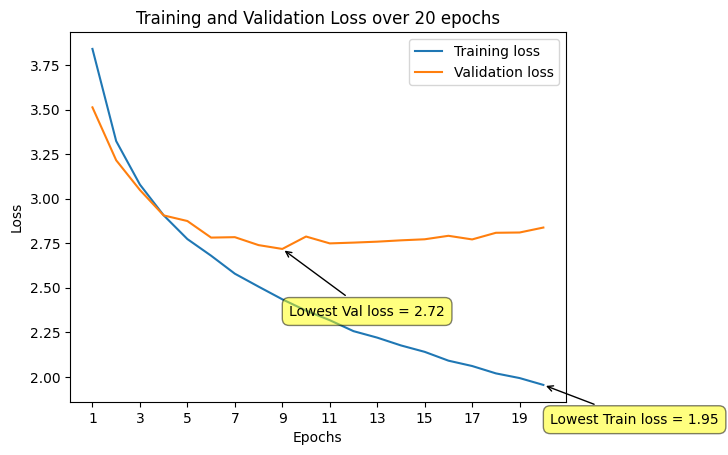

In [ ]:
# PLOT train_loss vs val_loss
epochs = range(1, 21)
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and Validation Loss over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21, 2))  # Show only integers with step size of 5
plt.annotate(f'Lowest Train loss = {min(train_losses):.2f}', xy=(train_losses.index(min(train_losses))+1, min(train_losses)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'Lowest Val loss = {min(val_losses):.2f}', xy=(val_losses.index(min(val_losses))+1, min(val_losses)),
             xytext=(5, -40), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.legend()
plt.show()

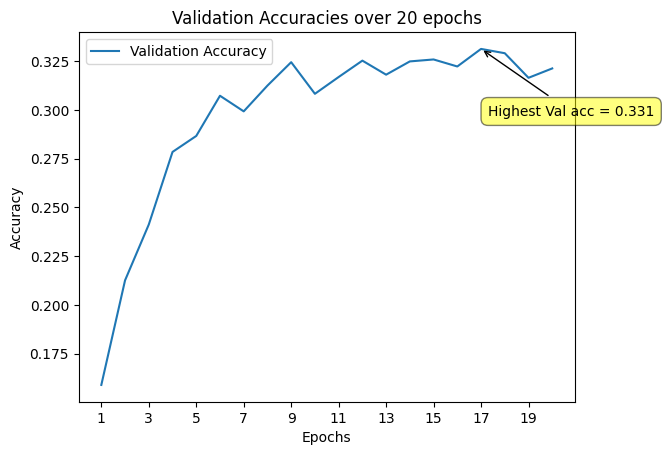

In [ ]:
epochs = range(1, 21)
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.title('Validation Accuracies over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21, 2))  # Show only integers with step size of 5
plt.annotate(f'Highest Val acc = {max(val_accs):.3f}', xy=(val_accs.index(max(val_accs))+1, max(val_accs)),
             xytext=(5, -40), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.legend()
plt.show()

### CIFAR10 Results Summary

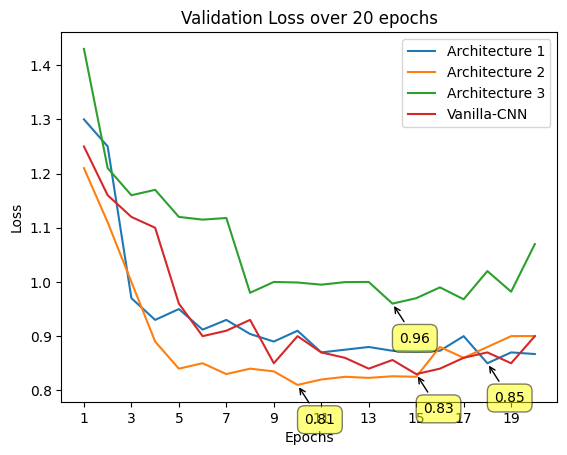

In [ ]:
epochs = range(1, 21)
loss_1 = np.load('new_model1_val_history.npy')
loss_1 = loss_1.tolist()
loss_2 = np.load('new_model2_val_history.npy')
loss_2 = loss_2.tolist()
loss_3 = np.load('new_model3_val_history.npy')
loss_3 = loss_3.tolist()
loss_4 = np.load('cnn_val_history.npy')
loss_4 = loss_4.tolist()
plt.plot(epochs, loss_1, label='Architecture 1')
plt.plot(epochs, loss_2, label='Architecture 2')
plt.plot(epochs, loss_3, label='Architecture 3')
plt.plot(epochs, loss_4, label='Vanilla-CNN')
plt.title('Validation Loss over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{min(loss_1):.2f}', xy=(loss_1.index(min(loss_1))+1, min(loss_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{min(loss_2):.2f}', xy=(loss_2.index(min(loss_2))+1, min(loss_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_3):.2f}', xy=(loss_3.index(min(loss_3))+1, min(loss_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_4):.2f}', xy=(loss_4.index(min(loss_4))+1, min(loss_4)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('val_loss.png')
plt.show()

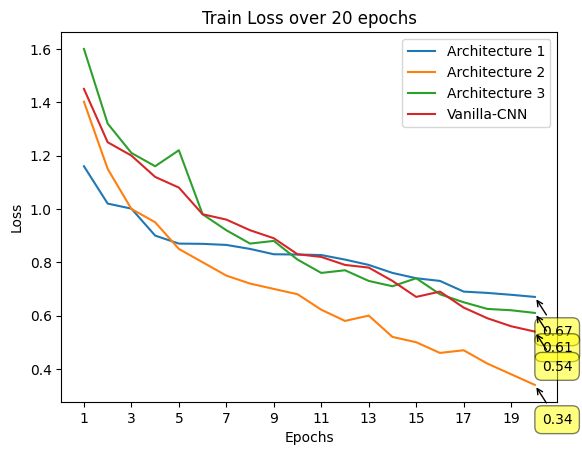

In [ ]:
epochs = range(1, 21)
loss_1 = np.load('new_model1_train_his.npy')
loss_1 = loss_1.tolist()
loss_2 = np.load('new_model2_train_his.npy')
loss_2 = loss_2.tolist()
loss_3 = np.load('new_model3_train_his.npy')
loss_3 = loss_3.tolist()
loss_4 = np.load('cnn_train_his.npy')
loss_4 = loss_4.tolist()
plt.plot(epochs, loss_1, label='Architecture 1')
plt.plot(epochs, loss_2, label='Architecture 2')
plt.plot(epochs, loss_3, label='Architecture 3')
plt.plot(epochs, loss_4, label='Vanilla-CNN')
plt.title('Train Loss over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{min(loss_1):.2f}', xy=(loss_1.index(min(loss_1))+1, min(loss_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{min(loss_2):.2f}', xy=(loss_2.index(min(loss_2))+1, min(loss_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_3):.2f}', xy=(loss_3.index(min(loss_3))+1, min(loss_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_4):.2f}', xy=(loss_4.index(min(loss_4))+1, min(loss_4)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('train_loss.png')
plt.show()

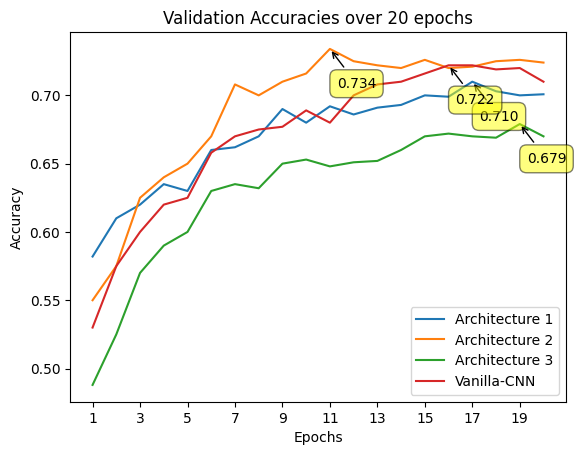

In [ ]:
epochs = range(1, 21)
acc_1 = np.load('new_model1_val_acc.npy')
acc_1 = acc_1.tolist()
acc_2 = np.load('new_model2_val_acc.npy')
acc_2 = acc_2.tolist()
acc_3 = np.load('new_model3_val_acc.npy')
acc_3 = acc_3.tolist()
acc_cnn = np.load('cnn_val_acc.npy')
acc_cnn = acc_cnn.tolist()
plt.plot(epochs, acc_1, label='Architecture 1')
plt.plot(epochs, acc_2, label='Architecture 2')
plt.plot(epochs, acc_3, label='Architecture 3')
plt.plot(epochs, acc_cnn, label='Vanilla-CNN')
plt.title('Validation Accuracies over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{max(acc_1):.3f}', xy=(acc_1.index(max(acc_1))+1, max(acc_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{max(acc_2):.3f}', xy=(acc_2.index(max(acc_2))+1, max(acc_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{max(acc_3):.3f}', xy=(acc_3.index(max(acc_3))+1, max(acc_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{max(acc_cnn):.3f}', xy=(acc_cnn.index(max(acc_cnn))+1, max(acc_cnn)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('val_acc.png')
plt.show()


### CIFAR100 Results Summary

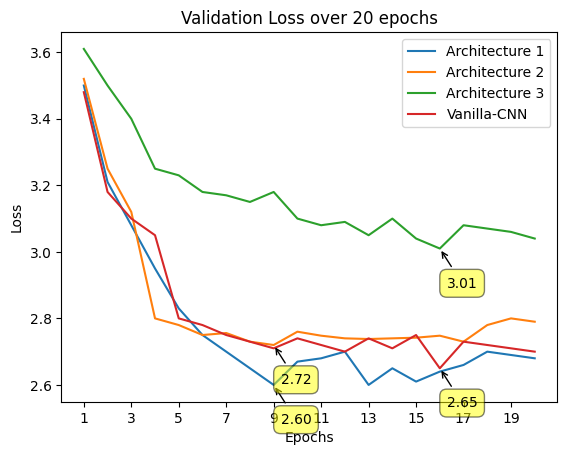

In [ ]:
epochs = range(1, 21)
loss_1 = np.load('new_model1_val_loss_100.npy')
loss_1 = loss_1.tolist()
loss_2 = np.load('new_model2_val_loss_100.npy')
loss_2 = loss_2.tolist()
loss_3 = np.load('new_model3_val_loss_100.npy')
loss_3 = loss_3.tolist()
cnn_loss = np.load('cnn_val_loss_100.npy')
cnn_loss = cnn_loss.tolist()
plt.plot(epochs, loss_1, label='Architecture 1')
plt.plot(epochs, loss_2, label='Architecture 2')
plt.plot(epochs, loss_3, label='Architecture 3')
plt.plot(epochs, loss_4, label='Vanilla-CNN')
plt.title('Validation Loss over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{min(loss_1):.2f}', xy=(loss_1.index(min(loss_1))+1, min(loss_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{min(loss_2):.2f}', xy=(loss_2.index(min(loss_2))+1, min(loss_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_3):.2f}', xy=(loss_3.index(min(loss_3))+1, min(loss_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(cnn_loss):.2f}', xy=(cnn_loss.index(min(cnn_loss))+1, min(cnn_loss)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('val_loss_100.png')
plt.show()


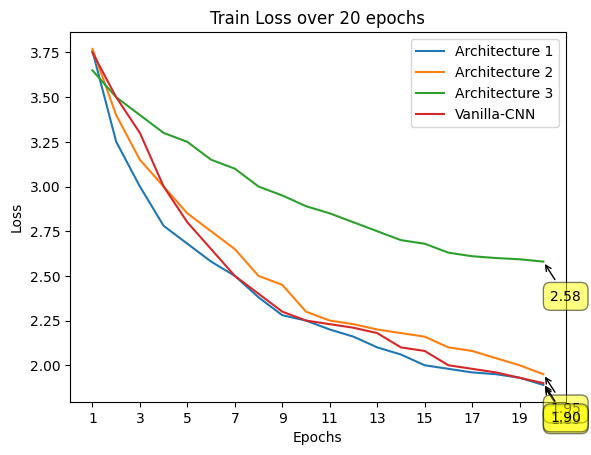

In [ ]:
epochs = range(1, 21)
loss_1 = np.load('new_model1_train_loss_100.npy')
loss_1 = loss_1.tolist()
loss_2 = np.load('new_model2_train_loss_100.npy')
loss_2 = loss_2.tolist()
loss_3 = np.load('new_model3_train_loss_100.npy')
loss_3 = loss_3.tolist()
cnn_loss = np.load('cnn_train_loss_100.npy')
cnn_loss = cnn_loss.tolist()
plt.plot(epochs, loss_1, label='Architecture 1')
plt.plot(epochs, loss_2, label='Architecture 2')
plt.plot(epochs, loss_3, label='Architecture 3')
plt.plot(epochs, cnn_loss, label='Vanilla-CNN')
plt.title('Train Loss over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{min(loss_1):.2f}', xy=(loss_1.index(min(loss_1))+1, min(loss_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{min(loss_2):.2f}', xy=(loss_2.index(min(loss_2))+1, min(loss_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(loss_3):.2f}', xy=(loss_3.index(min(loss_3))+1, min(loss_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{min(cnn_loss):.2f}', xy=(cnn_loss.index(min(cnn_loss))+1, min(cnn_loss)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('train_loss_100.png')
plt.show()



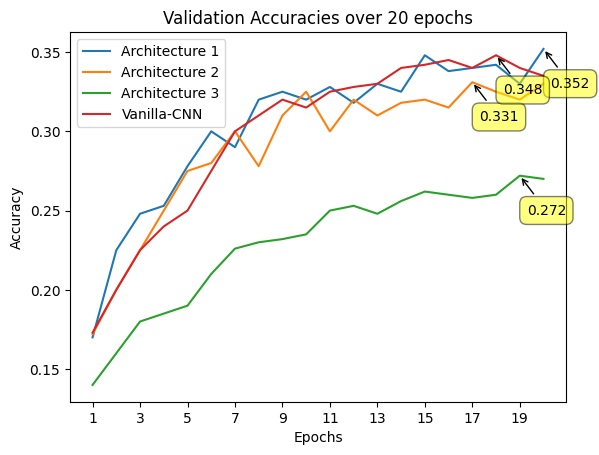

In [ ]:
epochs = range(1, 21)
acc_1 = np.load('new_model1_test_acc_100.npy')
acc_1 = acc_1.tolist()
acc_2 = np.load('new_model2_test_acc_100.npy')
acc_2 = acc_2.tolist()
acc_3 = np.load('new_model3_test_acc_100.npy')
acc_3 = acc_3.tolist()
cnn_acc = np.load('cnn_test_acc_100.npy')
cnn_acc = cnn_acc.tolist()
plt.plot(epochs, loss_1, label='Architecture 1')
plt.plot(epochs, loss_2, label='Architecture 2')
plt.plot(epochs, loss_3, label='Architecture 3')
plt.plot(epochs, loss_4, label='Vanilla-CNN')
plt.title('Validation Accuracies over 20 epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21, 2))

plt.annotate(f'{max(acc_1):.3f}', xy=(acc_1.index(max(acc_1))+1, max(acc_1)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.annotate(f'{max(acc_2):.3f}', xy=(acc_2.index(max(acc_2))+1, max(acc_2)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{max(acc_3):.3f}', xy=(acc_3.index(max(acc_3))+1, max(acc_3)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.annotate(f'{max(cnn_acc):.3f}', xy=(cnn_acc.index(max(cnn_acc))+1, max(cnn_acc)),
             xytext=(5, -20), textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.savefig('val_acc_100.png')
plt.show()

In [ ]:
# TESTING
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader), 100*correct/total))

Accuracy of the network on the 157 test images: 27.29 %


## Visualization

In [ ]:
model = torch.load('proposed_model2/cifar10_best_val_acc_of_0.672800.pt')

In [ ]:
class GradCamAttentionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = model
        self.layerhook.append(self.pretrained.conv3.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out


In [ ]:
gcmodel = GradCamAttentionCNN()

In [ ]:
BATCH_SIZE = 4

test_loader = data_loader(data_dir='./data',
                              batch_size=BATCH_SIZE,
                              test=True)

Files already downloaded and verified


In [ ]:
def compute_gradcam():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    imgs, heatmaps = [], []
    for i in range(BATCH_SIZE):
        img, label = images[i].unsqueeze(0), labels[i].unsqueeze(0)
        outputs, acts = gcmodel(img)
        _, predicted = torch.max(outputs.data, 1)
        acts = acts.detach().cpu()
        loss = criterion(outputs, label)
        loss.backward()

        print(label == predicted)
        grads = gcmodel.get_act_grads().detach().cpu()

        pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

        for i in range(acts.shape[1]):
            acts[:,i,:,:] *= pooled_grads[i]
        
        heatmap_j = torch.mean(acts, dim = 1).squeeze()
        heatmap_j_max = heatmap_j.max(axis = 0)[0]
        heatmap_j /= heatmap_j_max
        heatmap_j =  heatmap_j.numpy()
        heatmap_j = resize(heatmap_j,(32,32),preserve_range=True)
        cmap = mpl.cm.get_cmap('jet',256)
        heatmap_j2 = cmap(heatmap_j,alpha = 0.2)
        
        img = img.squeeze(0)

        imgs.append(img)
        heatmaps.append(heatmap_j2)
    
    return imgs, heatmaps

In [ ]:
imgs, heatmaps = compute_gradcam()

tensor([True])
tensor([True])
tensor([True])
tensor([False])


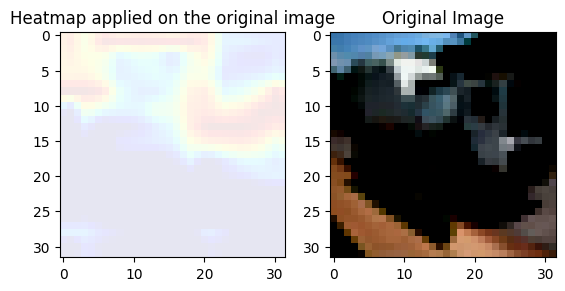

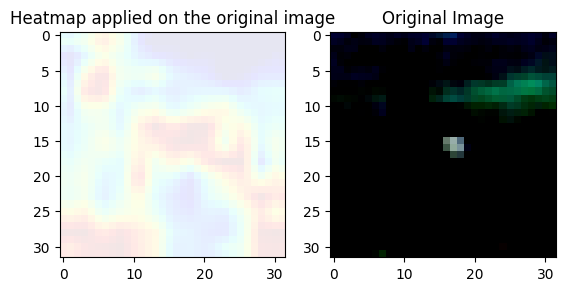

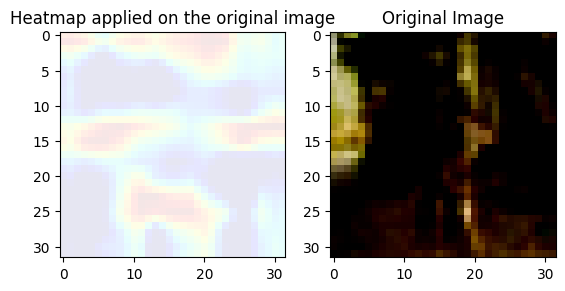

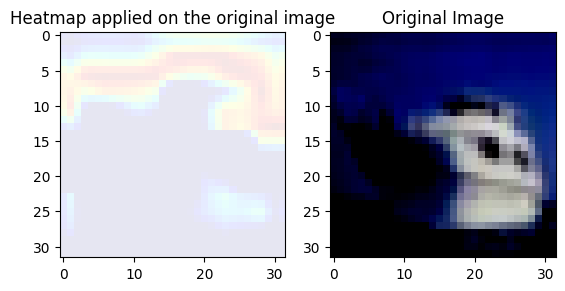

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for i in range(len(imgs)):
    # plot image B over image A
    fig, axs = plt.subplots(1, 2)
    # axs[0].imshow(np.transpose(imgs[i], (1, 2, 0)))
    axs[0].imshow(heatmaps[i], alpha=0.5)
    axs[0].set_title('Heatmap applied on the original image')

    # plot only image A
    axs[1].imshow(np.transpose(imgs[i], (1, 2, 0)))
    axs[1].set_title('Original Image')

    plt.show()